# Sandy waterfalls

- https://adventofcode.com/2022/day/14

Today's puzzle references back to [2018 Day 17](../2018/Day%2017.ipynb), with good reason! This is, essentially, the exact same problem but with added diagonals as the sand piles up. Except, that makes the problem entirely different.

In this case, it is actually easier to just keep a set of obstacle coordinates. Sand follows a path past the obstacles until it comes to rest, adding to the obstacles. At some point, sand passes below the lowest `y` coordinate, at which point you are done. Do note that each sandgrain follows the exact same path as the previous grain, minus the last step!


In [1]:
from dataclasses import dataclass
from itertools import product
from typing import Final, Iterable, Iterator, NamedTuple, Self


class Pos(NamedTuple):
    x: int
    y: int

    def __add__(self, other: Self) -> Self:
        return Pos(self.x + other.x, self.y + other.y)


DIRECTIONS: Final[tuple[Pos, Pos, Pos]] = (Pos(0, 1), Pos(-1, 1), Pos(1, 1))


@dataclass
class Cave:
    rock: set[Pos]

    @classmethod
    def from_rock_lines(cls, lines: Iterable[str]) -> Self:
        rock: set[Pos] = set()
        for line in lines:
            coords = iter(map(int, coord.split(",")) for coord in line.split("->"))
            fx, fy = next(coords)
            for tx, ty in coords:
                dx, dy = 1 if tx > fx else -1, 1 if ty > fy else -1
                rock.update(
                    Pos(x, y)
                    for x, y in product(range(fx, tx + dx, dx), range(fy, ty + dy, dy))
                )
                fx, fy = tx, ty
        return cls(rock)

    def simulate_sand(self, with_floor: bool = False) -> Iterator[Pos]:
        occupied = set(self.rock)
        # set the boundaries; max_y is the point at which grains will enter
        # free-fall, or for part 2, hit the floor.
        max_y = max(p.y for p in occupied) + with_floor
        sand_path = [Pos(500, 0)]
        while True:
            if not sand_path:  # starting point was popped of
                return
            while True:
                for d in DIRECTIONS:
                    if (grain := sand_path[-1] + d) not in occupied:
                        if grain.y <= max_y:
                            sand_path.append(grain)
                            break
                        if not with_floor:
                            return
                else:
                    grain = sand_path.pop()
                    occupied.add(grain)
                    yield grain
                    break


example = Cave.from_rock_lines(
    ["498,4 -> 498,6 -> 496,6", "503,4 -> 502,4 -> 502,9 -> 494,9"]
)
assert sum(1 for _ in example.simulate_sand()) == 24

In [2]:
import aocd

cave = Cave.from_rock_lines(aocd.get_data(day=14, year=2022).splitlines())
print("Part 1:", sum(1 for _ in cave.simulate_sand()))

Part 1: 683


## Part 2 bottoms out

In part 2, we need to add an infinite floor past our maximum Y coordinate. I've refactored my code to update the maximum by 1 as that means the new sand grain coordinate would have to penetrate this infinitely-wide floor at that point. I also needed to add a new check for the grain not having moved, and we are done! Just take into account that we need to return the current grain counter plus 1, as it is the next grain that'll be blocked.


In [3]:
assert sum(1 for _ in example.simulate_sand(with_floor=True)) == 93

In [4]:
print("Part 2:", sum(1 for _ in cave.simulate_sand(with_floor=True)))

Part 2: 28821


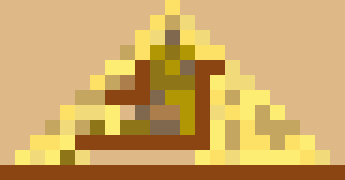

In [5]:
from random import choice

from PIL import Image


def visualise(cave: Cave, scale=1) -> Image.Image:
    maxy = max(p.y for p in cave.rock) + 2
    minx, maxx = 500 - maxy, 500 + maxy  # equilateral triangles
    width, height = maxx - minx + 1, maxy + 1
    img = Image.new("RGB", (width, height), (0xDE, 0xB8, 0x87))
    rock = (0x8B, 0x45, 0x13)
    part1_sand = (
        (0x7F, 0x68, 0x4E),
        (0x8E, 0x76, 0x18),
        (0xAB, 0x7E, 0x4C),
        (0xB2, 0x97, 0x05),
    )
    part2_sand = (
        (0xFD, 0xEE, 0x73),
        (0xC4, 0xA6, 0x61),
        (0xF1, 0xDA, 0x7A),
        (0xFC, 0xE1, 0x66),
    )
    sand = part1_sand
    for point in cave.rock:
        img.putpixel((point.x - minx, point.y), rock)
    for x in range(minx, maxx + 1):
        img.putpixel((x - minx, maxy), rock)
    for point in cave.simulate_sand(True):
        img.putpixel((point.x - minx, point.y), choice(sand))
        if sand == part1_sand and point.y > maxy - 2:
            # part 2
            sand = part2_sand
    if scale != 1:
        img = img.resize(
            (img.width * scale, img.height * scale), Image.Resampling.NEAREST
        )
    return img


visualise(example, 15)

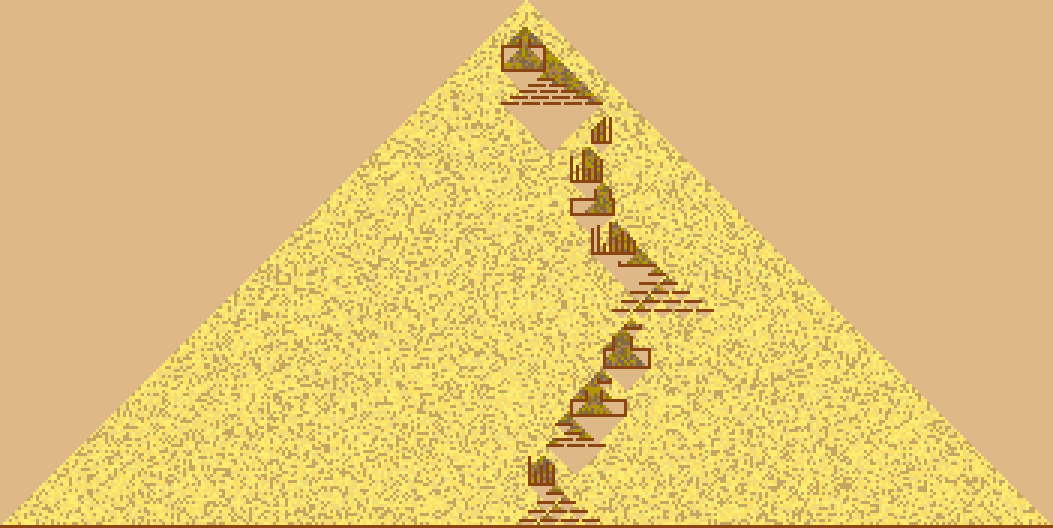

In [6]:
visualise(cave, 3)